In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # Only for data :)
%matplotlib inline

2022-09-12 13:04:07.393292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/sairam6087/miniconda3/envs/art-of-saience/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Load Dataset and Normalize

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [5]:
# Reshape and normalize
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))
X_test_reshaped = X_test.reshape((X_test.shape[0], -1))

In [6]:
X_train_reshaped.shape, X_test_reshaped.shape

((50000, 3072), (10000, 3072))

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_reshaped)
X_test_norm = scaler.transform(X_test_reshaped)

In [8]:
# Check mean and std 
np.mean(X_train_norm), np.std(X_train_norm)

(3.85173374676621e-18, 0.9999999999999963)

## Build KNN Classifier

In [11]:
class KNNClassifier:
    def __init__(self, k, X_tr, y_tr):
        self.k = k
        self.X_train = X_tr 
        self.y_train = y_tr
    
    # Compute Distance between train and test samples
    def compute_dist(self, X_tst):
        assert self.X_train.shape[1] == X_tst.shape[1] # Same feature dims
        n_test = X_tst.shape[0]

        # Optimized Distance Computation : no loops
        train_sq = np.sum(self.X_train**2, axis=1).reshape(1, self.X_train.shape[0])
        test_sq = np.sum(X_tst**2, axis=1).reshape(n_test, 1)

        dists = np.sqrt(train_sq + test_sq - 2 * np.dot(X_tst, self.X_train.T))
        return dists
    
    def predict(self, X_tst):
        n_test = X_tst.shape[0]
        dists = self.compute_dist(X_tst)

        y_preds = np.zeros(n_test)

        for i in range(n_test):
            sorted_dist = np.argsort(dists[i])
            y_closest = self.y_train[sorted_dist][:self.k].squeeze()

            y_preds[i] = np.argmax(np.bincount(y_closest))
        
        return y_preds 

In [12]:
knn = KNNClassifier(5, X_train_norm, y_train)
predictions = knn.predict(X_test_norm)

In [13]:
predictions[:10]

array([2., 8., 8., 0., 4., 6., 6., 2., 4., 8.])

In [14]:
y_test[:10].T

array([[3, 8, 8, 0, 6, 6, 1, 6, 3, 1]], dtype=uint8)

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions.T)

0.3417

## Breakdown of KNN

### Distance Function Optimization

#### Two loops

In [19]:
def compute_l2_two_loops(X_tr, X_tst):
    n_tr, n_tst = X_tr.shape[0], X_tst.shape[0]

    dists = np.zeros((n_tst, n_tr))

    for i in range(n_tst):
        for j in range(n_tr):
            dists[i, j] = np.linalg.norm(X_tr[j] - X_tst[i])
    
    return dists 

In [20]:
X_tr_sample = X_train_norm[:1000]
X_tst_sample = X_test_norm[:500] # Mainly for profiling

In [21]:
%%timeit 
compute_l2_two_loops(X_tr_sample, X_tst_sample)

4.1 s ± 247 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### One Loop

In [22]:
def compute_l2_one_loop(X_tr, X_tst):
    n_tr, n_tst = X_tr.shape[0], X_tst.shape[0]

    dists = np.zeros((n_tst, n_tr))    

    for i in range(n_tst):
        dists[i, :] = np.linalg.norm(X_tr - X_tst[i], axis=1)
    
    return dists

In [23]:
%%timeit
compute_l2_one_loop(X_tr_sample, X_tst_sample)

7.85 s ± 554 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### No Loops

In [24]:
def compute_l2_no_loop(X_tr, X_tst):
    n_tr, n_tst = X_tr.shape[0], X_tst.shape[0]

    # Optimized Distance Computation : no loops
    train_sq = np.sum(X_tr**2, axis=1).reshape(1, X_tr.shape[0])
    test_sq = np.sum(X_tst**2, axis=1).reshape(n_tst, 1)

    dists = np.sqrt(train_sq + test_sq - 2 * np.dot(X_tst, X_tr.T))
    return dists

In [25]:
%%timeit
compute_l2_no_loop(X_tr_sample, X_tst_sample)

55.3 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
# Check accuracy
l2_no_loop = compute_l2_no_loop(X_tr_sample, X_tst_sample)
l2_one_loop = compute_l2_one_loop(X_tr_sample, X_tst_sample)
l2_two_loop = compute_l2_two_loops(X_tr_sample, X_tst_sample)

In [27]:
np.linalg.norm(l2_two_loop - l2_one_loop)

4.96795530976107e-12

In [28]:
np.linalg.norm(l2_two_loop - l2_no_loop)

5.74787462376379e-12

### Visualize Nearest Neighbors

In [29]:
class KNNClassifierViz:
    def __init__(self, k, X_tr, y_tr):
        self.k = k
        self.X_train = X_tr 
        self.y_train = y_tr
    
    # Compute Distance between train and test samples
    def compute_dist(self, X_tst):
        assert self.X_train.shape[1] == X_tst.shape[1] # Same feature dims
        n_test = X_tst.shape[0]

        # Optimized Distance Computation : no loops
        train_sq = np.sum(self.X_train**2, axis=1).reshape(1, self.X_train.shape[0])
        test_sq = np.sum(X_tst**2, axis=1).reshape(n_test, 1)

        dists = np.sqrt(train_sq + test_sq - 2 * np.dot(X_tst, self.X_train.T))
        return dists
    
    def predict(self, X_tst):
        n_test = X_tst.shape[0]
        dists = self.compute_dist(X_tst)

        y_preds = np.zeros(n_test)
        X_preds = np.zeros((n_test, self.k, X_tst.shape[1])) # Return K closest images

        for i in range(n_test):
            sorted_dist = np.argsort(dists[i])
            y_closest = self.y_train[sorted_dist][:self.k].squeeze()
            X_closest = self.X_train[sorted_dist][:self.k]

            y_preds[i] = np.argmax(np.bincount(y_closest))
            X_preds[i] = X_closest
        
        return y_preds, X_preds  

In [30]:
knn_viz = KNNClassifierViz(5, X_train_norm[:1000], y_train[:1000])
preds_viz, candidates_viz = knn_viz.predict(X_test_norm[:10])

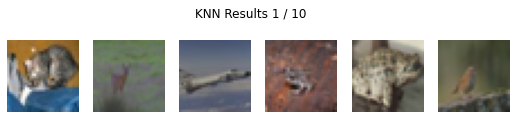

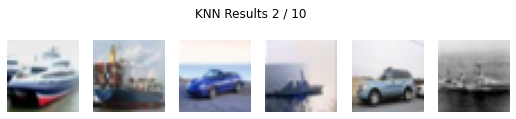

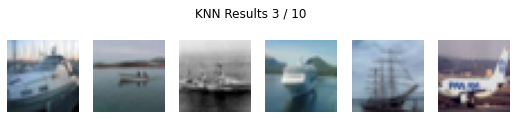

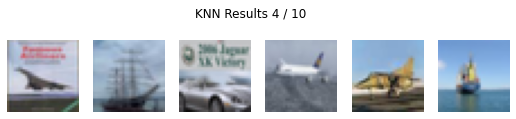

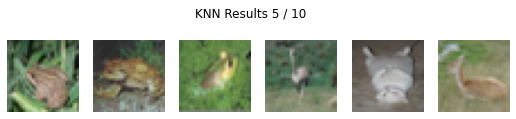

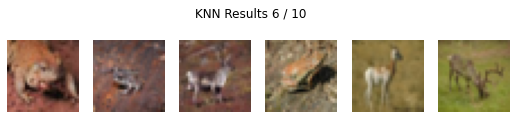

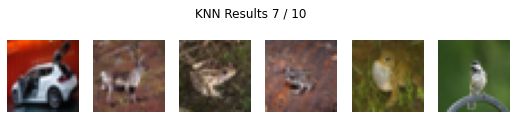

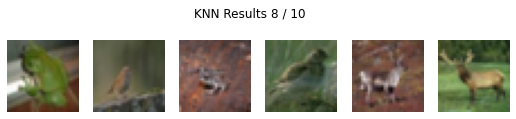

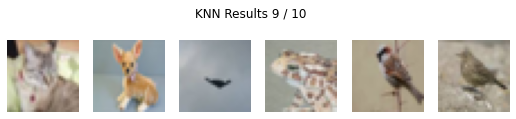

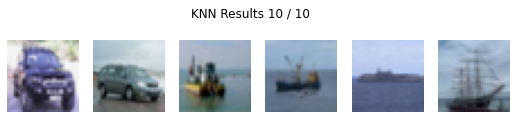

In [31]:
for i in range(10):
    fig, axs = plt.subplots(1, 6, figsize= (9,2), sharey=True)
    ref_img = X_test[i]
    pred_imgs = np.zeros((5, X_test[i].shape[0], X_test[i].shape[1], X_test[i].shape[2]))

    for j in range(5):
        pred_imgs[j] = scaler.inverse_transform(candidates_viz[i][j].reshape(1, -1)).reshape(X_test[i].shape)
    
    fig.suptitle(f"KNN Results {i + 1} / 10")
    axs[0].imshow(ref_img); # Plot query image
    axs[0].axis("off")

    for j in range(5):
        axs[j + 1].imshow(pred_imgs[j].astype(np.uint8));
        axs[j + 1].axis("off")